# Proof of concept. Data mining of imported logfile content with Anaconda. Inaki Fernandez. November 2015

- Environment: Anaconda 3 x86_64  for windows 10 x86_64 (Python3)
- Python packages added:
    - conda/pip install pandas_highcharts
    - conda install seaborn
- Installed Windows programs required for exporting this notebook to PDF: 
    - Pandoc
    - TeX Live 2015 (LaTeX)
- Motivation:
    - This proof of concept was developed by the author during a recruitment process: a Python programming test to be completed in 3 hours. Only a first design with a basic prototype was delivered, but a couple of updates were handled over in the following days with the final outcome.
    - The programing test was about importing a custom large log file where specific entries needed to be filtered out and imported for data mining purposes. 
    - The author of this notebook decided to deliver added value and develop a proof of concept based on Anaconda analytics instead of a traditional solution based on Python + vim + awk + sed.
    - The 3 pages long detailed requirements are not included in order to preserve anonymity of the Company and privacy of their recruitment test. 
- Ideas for improvement:
    - mmap module as the most efficient way to read large log files 
    - syslog module to deal with Syslog file rotation

In [58]:
# Standard
import tempfile
import os
import sys
import pyparsing
from pyparsing import Word, alphas, Suppress, Combine, nums, string, Optional, Regex, ParseException
from datetime import datetime
import pandas as pd
import numpy as np
from numpy.random import randn
# Stats
from scipy import stats
from pylab import *
# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

%pylab inline
%matplotlib inline


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [59]:
logfilecontent = '''
Feb 25 12:40:12 victim /opt/zl/bin/zdaemon[29412]: [zl::esink::Internals::timeout][/m0/zdaemon3]: Interval(5000): \
numCycles(173) numTimeouts(89) numMessages(241) numTMessages(2) numDescriptors(48) numPipes(0) task-events(0) num-timers(439) 
Feb 25 12:40:17 victim /opt/zl/bin/zdaemon[29412]: [zl::esink::Internals::timeout][/m0/zdaemon3]: Interval(5000): \
numCycles(17) numTimeouts(82) numMessages(247) numTMessages(3) numDescriptors(54) numPipes(0) task-events(0) num-timers(454)
other logs 1
Feb 25 12:40:22 victim /opt/zl/bin/zdaemon[29412]: [zl::esink::Internals::timeout][/m0/zdaemon3]: Interval(5000): \
numCycles(12) numTimeouts(2) numMessages(242) numTMessages(5) numDescriptors(67) numPipes(0) task-events(0) num-timers(499)
Feb 25 12:40:27 victim /opt/zl/bin/zdaemon[29412]: [zl::esink::Internals::timeout][/m0/zdaemon3]: Interval(5000): \
numCycles(7) numTimeouts(32) numMessages(189) numTMessages(8) numDescriptors(60) numPipes(0) task-events(0) num-timers(413)
Feb 25 12:40:32 victim /opt/zl/bin/zdaemon[29412]: [zl::esink::Internals::timeout][/m0/zdaemon3]: Interval(5000): \
numCycles(18) numTimeouts(21) numMessages(310) numTMessages(3) numDescriptors(78) numPipes(0) task-events(0) num-timers(505)
other logs 2
Feb 25 12:40:37 victim /opt/zl/bin/zdaemon[29412]: [zl::esink::Internals::timeout][/m0/zdaemon3]: Interval(5000): \
numCycles(22) numTimeouts(17) numMessages(233) numTMessages(6) numDescriptors(65) numPipes(0) task-events(0) num-timers(569)
'''


In [60]:
month = Word(string.ascii_letters, string.ascii_letters, exact=3)
integer = Word(nums)
serverDateTime = Combine(month + " " + integer + " " + integer + ":" + integer + ":" + integer)
hostname = Word(alphas + nums + "_" + "-")
daemon = Word(alphas + "/" + "-" + "_" ) + Optional(Suppress("[") + integer + Suppress("]")) + Suppress(":")
zl = Suppress("[") + Word( alphas + "::" + alphas + "::" + alphas + "::" + alphas ) + Suppress("]")
m0 = Suppress("[") + Word( alphas + nums + "_" + "-" + "/" ) + Suppress("]") + Suppress(":")
interval = Suppress("Interval") + Suppress("(") + Word(nums) + Suppress("):") 
numCycles = Suppress("numCycles") + Suppress("(") + Word(nums) + Suppress(")") 
numTimeouts = Suppress("numTimeouts") + Suppress("(") + Word(nums) + Suppress(")")  
numMessages = Suppress("numMessages") + Suppress("(") + Word(nums) + Suppress(")")  
numTMessages = Suppress("numTMessages") + Suppress("(") + Word(nums) + Suppress(")") 
numDescriptors = Suppress("numDescriptors") + Suppress("(") + Word(nums) + Suppress(")") 
numPipes = Suppress("numPipes") + Suppress("(") + Word(nums) + Suppress(")") 
taskevents = Suppress("task-events") + Suppress("(") + Word(nums) + Suppress(")") 
numtimers = Suppress("num-timers") + Suppress("(") + Word(nums) + Suppress(")") 
bnf = (serverDateTime + hostname + daemon + zl + m0 + interval + numCycles + numTimeouts + 
       numMessages + numTMessages + numDescriptors + numPipes + taskevents + numtimers)


In [61]:
def make_tempfile():
    fd, temp_file_name = tempfile.mkstemp()
    os.close(fd)
    f = open(temp_file_name,'wt')
    try:
        f.write(logfilecontent)
    finally:
        f.close()
    return temp_file_name

def cleanup(filename):
    os.unlink(filename)
        
filename = make_tempfile()

L=list()
with open(filename) as infile:
   for line in infile:
        try:
           results = bnf.parseString(line)
        except ParseException as pe:
            continue
        else:
           L.append(results)
           
print(L)
cleanup(filename)        

[(['Feb 25 12:40:12', 'victim', '/opt/zl/bin/zdaemon', '29412', 'zl::esink::Internals::timeout', '/m0/zdaemon3', '5000', '173', '89', '241', '2', '48', '0', '0', '439'], {}), (['Feb 25 12:40:17', 'victim', '/opt/zl/bin/zdaemon', '29412', 'zl::esink::Internals::timeout', '/m0/zdaemon3', '5000', '17', '82', '247', '3', '54', '0', '0', '454'], {}), (['Feb 25 12:40:22', 'victim', '/opt/zl/bin/zdaemon', '29412', 'zl::esink::Internals::timeout', '/m0/zdaemon3', '5000', '12', '2', '242', '5', '67', '0', '0', '499'], {}), (['Feb 25 12:40:27', 'victim', '/opt/zl/bin/zdaemon', '29412', 'zl::esink::Internals::timeout', '/m0/zdaemon3', '5000', '7', '32', '189', '8', '60', '0', '0', '413'], {}), (['Feb 25 12:40:32', 'victim', '/opt/zl/bin/zdaemon', '29412', 'zl::esink::Internals::timeout', '/m0/zdaemon3', '5000', '18', '21', '310', '3', '78', '0', '0', '505'], {}), (['Feb 25 12:40:37', 'victim', '/opt/zl/bin/zdaemon', '29412', 'zl::esink::Internals::timeout', '/m0/zdaemon3', '5000', '22', '17', '23

In [62]:
# Columns naming 
dframe = pd.DataFrame(L,columns=['serverDateTime','hostname','daemon','daemon-p','zl','m0','interval','numcycles',
                                 'numtimeouts','nummessages','numtmessages','numdescriptors','numpipes','task-events',
                                 'num-timers'])


In [63]:
# dtype conversion to integer
dframe[['interval','numcycles','numtimeouts','nummessages','numtmessages','numdescriptors','numpipes','task-events',
        'num-timers']] = dframe[['interval','numcycles','numtimeouts','nummessages','numtmessages','numdescriptors',
                                 'numpipes','task-events','num-timers']].astype(int)
       

In [64]:
dframe

,serverDateTime,hostname,daemon,daemon-p,zl,m0,interval,numcycles,numtimeouts,nummessages,numtmessages,numdescriptors,numpipes,task-events,num-timers
0,Feb 25 12:40:12,victim,/opt/zl/bin/zdaemon,29412,zl::esink::Internals::timeout,/m0/zdaemon3,5000,173,89,241,2,48,0,0,439
1,Feb 25 12:40:17,victim,/opt/zl/bin/zdaemon,29412,zl::esink::Internals::timeout,/m0/zdaemon3,5000,17,82,247,3,54,0,0,454
2,Feb 25 12:40:22,victim,/opt/zl/bin/zdaemon,29412,zl::esink::Internals::timeout,/m0/zdaemon3,5000,12,2,242,5,67,0,0,499
3,Feb 25 12:40:27,victim,/opt/zl/bin/zdaemon,29412,zl::esink::Internals::timeout,/m0/zdaemon3,5000,7,32,189,8,60,0,0,413
4,Feb 25 12:40:32,victim,/opt/zl/bin/zdaemon,29412,zl::esink::Internals::timeout,/m0/zdaemon3,5000,18,21,310,3,78,0,0,505
5,Feb 25 12:40:37,victim,/opt/zl/bin/zdaemon,29412,zl::esink::Internals::timeout,/m0/zdaemon3,5000,22,17,233,6,65,0,0,569


In [65]:
dframe.columns

Index(['serverDateTime', 'hostname', 'daemon', 'daemon-p', 'zl', 'm0',
       'interval', 'numcycles', 'numtimeouts', 'nummessages', 'numtmessages',
       'numdescriptors', 'numpipes', 'task-events', 'num-timers'],
      dtype='object')

In [66]:
dframe.index

Int64Index([0, 1, 2, 3, 4, 5], dtype='int64')

In [67]:
dframe.columns

Index(['serverDateTime', 'hostname', 'daemon', 'daemon-p', 'zl', 'm0',
       'interval', 'numcycles', 'numtimeouts', 'nummessages', 'numtmessages',
       'numdescriptors', 'numpipes', 'task-events', 'num-timers'],
      dtype='object')

In [68]:
dframe['nummessages']

0    241
1    247
2    242
3    189
4    310
5    233
Name: nummessages, dtype: int32

In [69]:
sample_string2 = dframe['num-timers']

In [70]:
sample_string2

0    439
1    454
2    499
3    413
4    505
5    569
Name: num-timers, dtype: int32

In [71]:
del dframe['hostname']
del dframe['daemon']
del dframe['daemon-p']
del dframe['zl']
del dframe['m0']
del dframe['numpipes']
del dframe['task-events']

In [72]:
dframe

,serverDateTime,interval,numcycles,numtimeouts,nummessages,numtmessages,numdescriptors,num-timers
0,Feb 25 12:40:12,5000,173,89,241,2,48,439
1,Feb 25 12:40:17,5000,17,82,247,3,54,454
2,Feb 25 12:40:22,5000,12,2,242,5,67,499
3,Feb 25 12:40:27,5000,7,32,189,8,60,413
4,Feb 25 12:40:32,5000,18,21,310,3,78,505
5,Feb 25 12:40:37,5000,22,17,233,6,65,569


In [73]:
dframe[['nummessages','numtmessages']]

,nummessages,numtmessages
0,241,2
1,247,3
2,242,5
3,189,8
4,310,3
5,233,6


In [74]:
dframe2 = pd.DataFrame(dframe,columns=['numcycles','numtimeouts','nummessages','numtmessages'])

In [75]:
dframe2

,numcycles,numtimeouts,nummessages,numtmessages
0,173,89,241,2
1,17,82,247,3
2,12,2,242,5
3,7,32,189,8
4,18,21,310,3
5,22,17,233,6


In [76]:
dframe2.describe()

,numcycles,numtimeouts,nummessages,numtmessages
count,6.000000,6.000000,6.000000,6.000000
mean,41.500000,40.500000,243.666667,4.500000
std,64.630488,36.225681,38.790033,2.258318
min,7.000000,2.000000,189.000000,2.000000
25%,13.250000,18.000000,235.000000,3.000000
50%,17.500000,26.500000,241.500000,4.000000
75%,21.000000,69.500000,245.750000,5.750000
max,173.000000,89.000000,310.000000,8.000000


In [77]:
dframe2.index

Int64Index([0, 1, 2, 3, 4, 5], dtype='int64')

## Plotting copied dataframe with specific columns

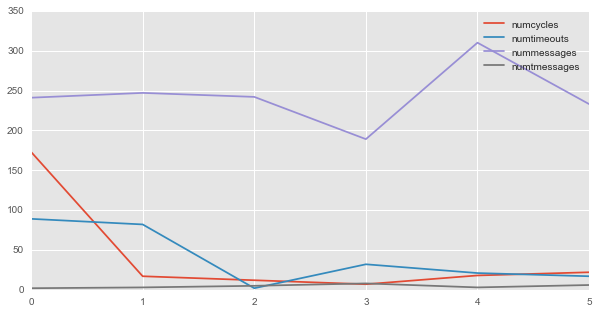

In [78]:
matplotlib.style.use('ggplot')
rcParams['figure.figsize'] = 10, 5 # width, height in inches
dframe2.plot()
legend()

In [79]:
dframe

,serverDateTime,interval,numcycles,numtimeouts,nummessages,numtmessages,numdescriptors,num-timers
0,Feb 25 12:40:12,5000,173,89,241,2,48,439
1,Feb 25 12:40:17,5000,17,82,247,3,54,454
2,Feb 25 12:40:22,5000,12,2,242,5,67,499
3,Feb 25 12:40:27,5000,7,32,189,8,60,413
4,Feb 25 12:40:32,5000,18,21,310,3,78,505
5,Feb 25 12:40:37,5000,22,17,233,6,65,569


In [80]:
dframe.index

Int64Index([0, 1, 2, 3, 4, 5], dtype='int64')

## Problem: Monitor should obtain the following information
 - The number of events per second for numCycles, numTimeouts, numMessages and numTMessages
 - The current value of numDescriptors and num-timers 
 - Solution: DataFrame manipulation 
 - Issue: serverDateTime is not in datetime format, pd.to_datetime will solve it although year is not specified in origin and Python's default year is 1900.

In [81]:
dframe['interval'] = dframe['interval']/1000
dframe['numcycles']=dframe['numcycles']/5
dframe['numtimeouts']=dframe['numtimeouts']/5
dframe['nummessages']=dframe['nummessages']/5
dframe['numtmessages']=dframe['numtmessages']/5
dframe['serverDateTime'] = pd.to_datetime(dframe['serverDateTime'],format='%b %d %H:%M:%S')
dframe['serverDateTime'].dt.year
dframe['serverDateTime']

0   1900-02-25 12:40:12
1   1900-02-25 12:40:17
2   1900-02-25 12:40:22
3   1900-02-25 12:40:27
4   1900-02-25 12:40:32
5   1900-02-25 12:40:37
Name: serverDateTime, dtype: datetime64[ns]

- Trying to fix the year issue: Year is not specified in logs' timestamp and default year in Python is 1900.
- Adding years to our current datetime is not valid as each year has a different amount of days. 
- The same applies to similar solutions

    - daysToAdd = 365 * 115
    - dframe['serverDateTime'] = dframe['serverDateTime'] + np.timedelta64(115, 'Y')
    - dframe['serverDateTime'] = dframe['serverDateTime'] + np.timedelta64(daysToAdd, 'D')

## Problem: Every 10 seconds, the program should emit all the counters to a file or a round-robin database for further processing and logging. 
- DatetimeIndex required for generating meaninful graphs and by dframe.resample
- We setup serverDateTime column as index in order to use dframe.resample below (DatetimeIndex)

In [82]:
#dframe.set_index('serverDateTime', drop=False, verify_integrity=True)
dframe.set_index('serverDateTime', drop=False, inplace=True)
dframe

,serverDateTime,interval,numcycles,numtimeouts,nummessages,numtmessages,numdescriptors,num-timers
serverDateTime,,,,,,,,
1900-02-25 12:40:12,1900-02-25 12:40:12,5,34.6,17.8,48.2,0.4,48,439
1900-02-25 12:40:17,1900-02-25 12:40:17,5,3.4,16.4,49.4,0.6,54,454
1900-02-25 12:40:22,1900-02-25 12:40:22,5,2.4,0.4,48.4,1.0,67,499
1900-02-25 12:40:27,1900-02-25 12:40:27,5,1.4,6.4,37.8,1.6,60,413
1900-02-25 12:40:32,1900-02-25 12:40:32,5,3.6,4.2,62.0,0.6,78,505
1900-02-25 12:40:37,1900-02-25 12:40:37,5,4.4,3.4,46.6,1.2,65,569


In [83]:
dframe.index

DatetimeIndex(['1900-02-25 12:40:12', '1900-02-25 12:40:17',
               '1900-02-25 12:40:22', '1900-02-25 12:40:27',
               '1900-02-25 12:40:32', '1900-02-25 12:40:37'],
              dtype='datetime64[ns]', name='serverDateTime', freq=None)

### Pandas has simple, powerful, and efficient functionality for performing resampling operations during frequency conversion (e.g., converting secondly data into 5-minutely data). This is extremely common in, but not limited to, financial applications. See the Time Series section 

In [84]:
# DataFrame.resample will show NaN rows. We are copying dframe to a new one in order to avoid issues afterwards 
# (pd.notnull not working properly)

dframe10s = dframe.copy(deep=True)
#dframe.resample('10min', how='sum')
#dframe10s.resample('10S', how='sum')   # 10S = 10 seconds
dframe10s.resample('10S', how='mean')  # 10S = 10 seconds, mean = average
#dframe10s[pd.notnull(dframe10s.resample('10S', how='mean'))]
#dframe10s[np.isfinite(dframe10s.resample('10S', how='mean'))]

,interval,numcycles,numtimeouts,nummessages,numtmessages,numdescriptors,num-timers
serverDateTime,,,,,,,
1900-02-25 12:40:10,5,19.0,17.1,48.8,0.5,51.0,446.5
1900-02-25 12:40:20,5,1.9,3.4,43.1,1.3,63.5,456.0
1900-02-25 12:40:30,5,4.0,3.8,54.3,0.9,71.5,537.0


In [85]:
dframe

,serverDateTime,interval,numcycles,numtimeouts,nummessages,numtmessages,numdescriptors,num-timers
serverDateTime,,,,,,,,
1900-02-25 12:40:12,1900-02-25 12:40:12,5,34.6,17.8,48.2,0.4,48,439
1900-02-25 12:40:17,1900-02-25 12:40:17,5,3.4,16.4,49.4,0.6,54,454
1900-02-25 12:40:22,1900-02-25 12:40:22,5,2.4,0.4,48.4,1.0,67,499
1900-02-25 12:40:27,1900-02-25 12:40:27,5,1.4,6.4,37.8,1.6,60,413
1900-02-25 12:40:32,1900-02-25 12:40:32,5,3.6,4.2,62.0,0.6,78,505
1900-02-25 12:40:37,1900-02-25 12:40:37,5,4.4,3.4,46.6,1.2,65,569


In [86]:
dframe.index

DatetimeIndex(['1900-02-25 12:40:12', '1900-02-25 12:40:17',
               '1900-02-25 12:40:22', '1900-02-25 12:40:27',
               '1900-02-25 12:40:32', '1900-02-25 12:40:37'],
              dtype='datetime64[ns]', name='serverDateTime', freq=None)

### Groupby per hour:

In [87]:
def func(group):
    return pd.Series({'numcycles': group.numcycles.sum(), 'numtimeouts': group.numtimeouts.sum(),
        'nummessages': group.nummessages.sum(), 'numtmessages': group.numtmessages.sum(), 'serverDateTime': group.index[1], 
                      'Period': '{0} - {1}'.format(group.index[0].date(), group.index[-1].date())})

dframe.groupby(lambda idx: idx.hour).apply(func)


,Period,numcycles,nummessages,numtimeouts,numtmessages,serverDateTime
12,1900-02-25 - 1900-02-25,49.8,292.4,48.6,5.4,1900-02-25 12:40:17


In [88]:
dframe

,serverDateTime,interval,numcycles,numtimeouts,nummessages,numtmessages,numdescriptors,num-timers
serverDateTime,,,,,,,,
1900-02-25 12:40:12,1900-02-25 12:40:12,5,34.6,17.8,48.2,0.4,48,439
1900-02-25 12:40:17,1900-02-25 12:40:17,5,3.4,16.4,49.4,0.6,54,454
1900-02-25 12:40:22,1900-02-25 12:40:22,5,2.4,0.4,48.4,1.0,67,499
1900-02-25 12:40:27,1900-02-25 12:40:27,5,1.4,6.4,37.8,1.6,60,413
1900-02-25 12:40:32,1900-02-25 12:40:32,5,3.6,4.2,62.0,0.6,78,505
1900-02-25 12:40:37,1900-02-25 12:40:37,5,4.4,3.4,46.6,1.2,65,569


### resample 10 min

In [89]:
dframe10min = dframe.copy(deep=True)
dframe10min.resample('10min', how='sum')

,interval,numcycles,numtimeouts,nummessages,numtmessages,numdescriptors,num-timers
serverDateTime,,,,,,,
1900-02-25 12:40:00,30,49.8,48.6,292.4,5.4,372,2879


In [90]:
dframe

,serverDateTime,interval,numcycles,numtimeouts,nummessages,numtmessages,numdescriptors,num-timers
serverDateTime,,,,,,,,
1900-02-25 12:40:12,1900-02-25 12:40:12,5,34.6,17.8,48.2,0.4,48,439
1900-02-25 12:40:17,1900-02-25 12:40:17,5,3.4,16.4,49.4,0.6,54,454
1900-02-25 12:40:22,1900-02-25 12:40:22,5,2.4,0.4,48.4,1.0,67,499
1900-02-25 12:40:27,1900-02-25 12:40:27,5,1.4,6.4,37.8,1.6,60,413
1900-02-25 12:40:32,1900-02-25 12:40:32,5,3.6,4.2,62.0,0.6,78,505
1900-02-25 12:40:37,1900-02-25 12:40:37,5,4.4,3.4,46.6,1.2,65,569


In [91]:
dframe.index

DatetimeIndex(['1900-02-25 12:40:12', '1900-02-25 12:40:17',
               '1900-02-25 12:40:22', '1900-02-25 12:40:27',
               '1900-02-25 12:40:32', '1900-02-25 12:40:37'],
              dtype='datetime64[ns]', name='serverDateTime', freq=None)

In [92]:
dframe['numcycles'].value_counts()

4.4     1
3.6     1
2.4     1
3.4     1
34.6    1
1.4     1
Name: numcycles, dtype: int64

## Graphs 
### Plotting with matplotlib

In [93]:
rcParams['figure.figsize'] = 10, 5 # width, height in inches

#df_s = dframe['numcycles'].resample('1S', how='sum')
#df_s.plot()


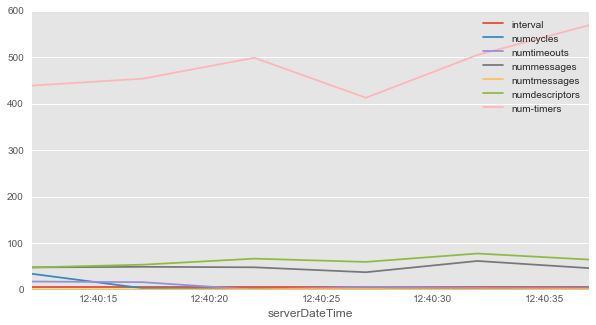

In [94]:
dframe.plot()
legend()

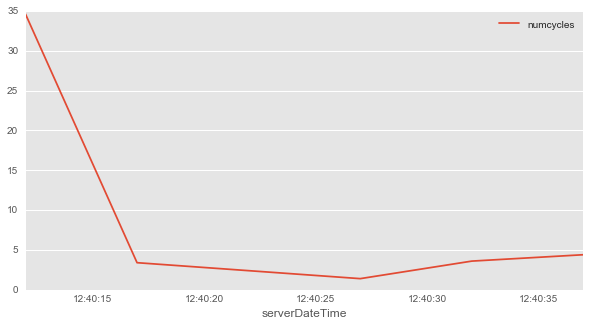

In [95]:
#dframe.resample("1D", how="sum")
dframe['numcycles'].plot()
legend()

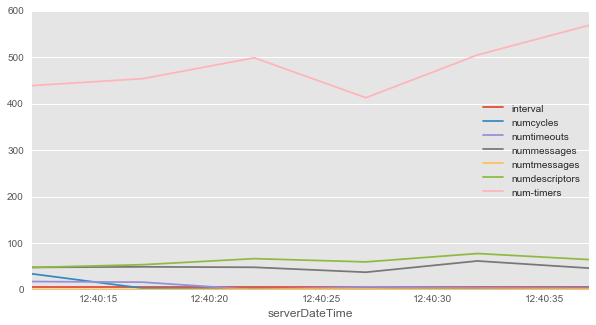

In [96]:
plt.figure();dframe.plot();

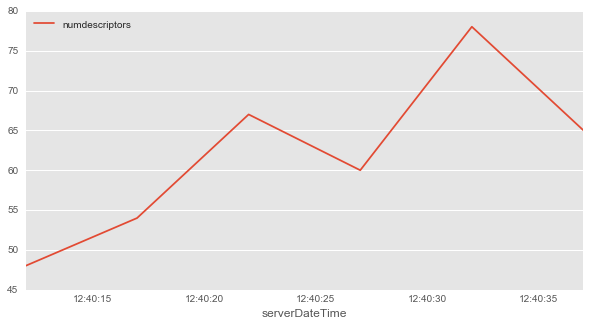

In [97]:
dframe.plot(x='serverDateTime',y='numdescriptors')

## Plotting with Seaborn
### Scatterplot

C:\Anaconda3\lib\site-packages\matplotlib\__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


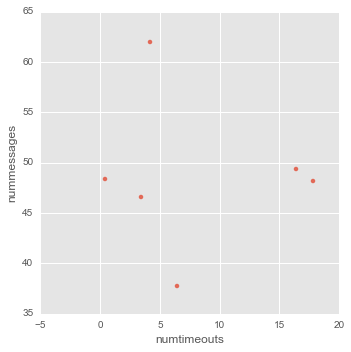

In [98]:
sns.lmplot('numtimeouts','nummessages', data=dframe, fit_reg=False)

### Density Plot. Kernel density estimation

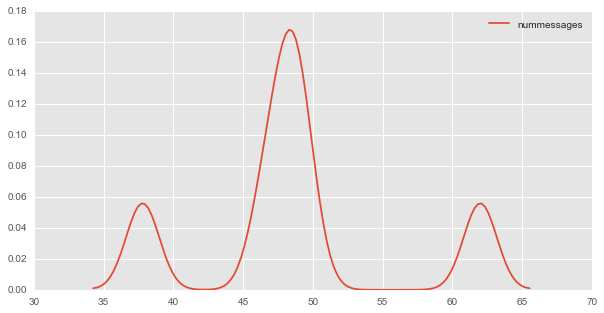

In [99]:
sns.kdeplot(dframe.nummessages)

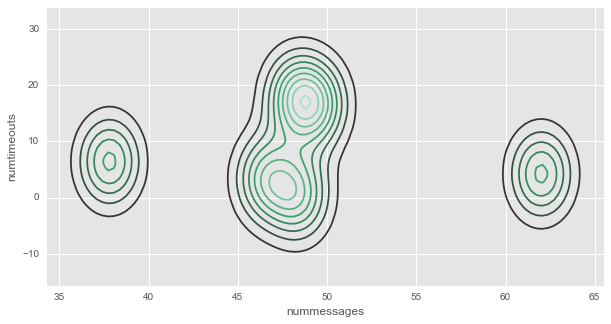

In [100]:
sns.kdeplot(dframe.nummessages, dframe.numtimeouts)

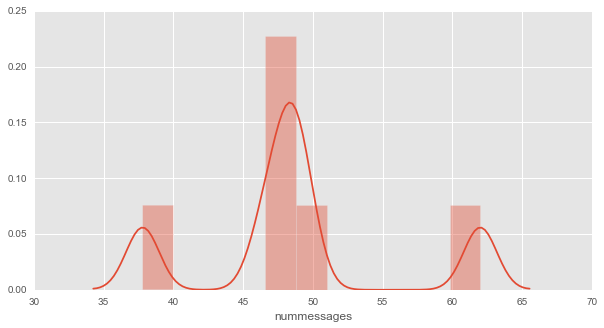

In [101]:
sns.distplot(dframe.nummessages)

### Histogram

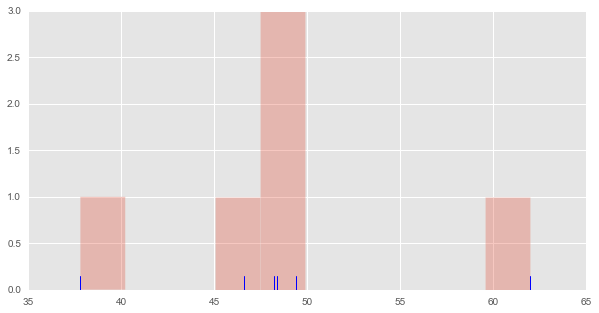

In [102]:
plt.hist(dframe.nummessages, alpha = .3)
sns.rugplot(dframe.nummessages);

### Violin Plot

C:\Anaconda3\lib\site-packages\matplotlib\__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


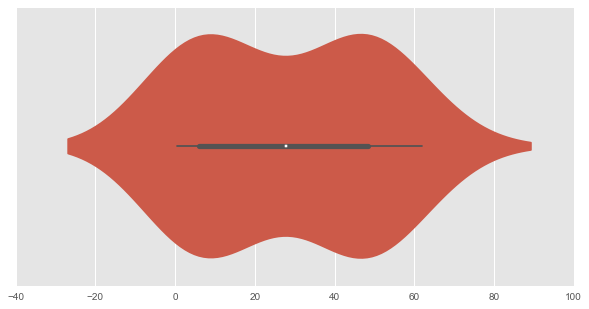

In [103]:
sns.violinplot([dframe.numtimeouts,dframe.nummessages])

### Heatmap

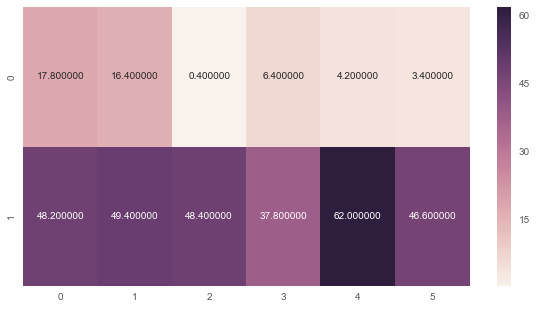

In [104]:
sns.heatmap([dframe.numtimeouts,dframe.nummessages], annot=True, fmt="f")

## Plotting with Pandas Highcharts 
- conda/pip install pandas_highcharts

In [105]:
from pandas.compat import StringIO
from pandas.io.common import urlopen
from IPython.display import display, display_pretty, Javascript, HTML
from pandas_highcharts.core import serialize
from pandas_highcharts.display import display_charts

In [106]:
display_charts(dframe, title="logs")

In [107]:
display_charts(dframe, kind="bar", title="rate")

In [108]:
display_charts(dframe, kind="barh", title="rate")

In [109]:
display_charts(dframe, title="rate", legend=None, kind="bar", figsize = (1000, 700))

In [110]:
display_charts(dframe, title="rate", kind="bar", render_to="chart5", zoom="xy")

## Obtain some values related with the machine load.
- There's no load average for the last 1, 5 and 15 minutes in my windows environment. In any case this is trivial task.
    - import psutil
    - mport os
    - os.getloadavg()
    - psutil.cpu_percent(percpu=True)


## Configurable threshold on the aggregated counters

In [111]:
dframe[(dframe.numtimeouts < 17) & (dframe.numtimeouts > 5)] 
#dframe[(dframe.numtimeouts < 50) & (dframe.numtimeouts > 20)] [['numtimeouts']]

,serverDateTime,interval,numcycles,numtimeouts,nummessages,numtmessages,numdescriptors,num-timers
serverDateTime,,,,,,,,
1900-02-25 12:40:17,1900-02-25 12:40:17,5,3.4,16.4,49.4,0.6,54,454
1900-02-25 12:40:27,1900-02-25 12:40:27,5,1.4,6.4,37.8,1.6,60,413


## Configurable threshold on the aggregated counters

In [112]:
dframe[dframe['numtimeouts']>6] 

,serverDateTime,interval,numcycles,numtimeouts,nummessages,numtmessages,numdescriptors,num-timers
serverDateTime,,,,,,,,
1900-02-25 12:40:12,1900-02-25 12:40:12,5,34.6,17.8,48.2,0.4,48,439
1900-02-25 12:40:17,1900-02-25 12:40:17,5,3.4,16.4,49.4,0.6,54,454
1900-02-25 12:40:27,1900-02-25 12:40:27,5,1.4,6.4,37.8,1.6,60,413


### Threshold checking via a conditional statement

In [113]:
if ~dframe[dframe['numtimeouts']>6].empty:
    print('DataFrame contains rows with numtimeouts bigger than threshold!')
    
#dframe3 = dframe[dframe['numtimeouts']>6]
#dframe3 is not None and isinstance(dframe3, pd.DataFrame) and not dframe3.empty  

DataFrame contains rows with numtimeouts bigger than threshold!


### Display an index/row

In [114]:
dframe.ix['1900-02-25 12:40:17']

,serverDateTime,interval,numcycles,numtimeouts,nummessages,numtmessages,numdescriptors,num-timers
serverDateTime,,,,,,,,
1900-02-25 12:40:17,1900-02-25 12:40:17,5,3.4,16.4,49.4,0.6,54,454
